# Exponential Smoothing

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt
%matplotlib inline

In [2]:
df = pd.read_csv('/content/drive/MyDrive/data/2/Electric_Production.csv')
df.head()

,DATE,IPG2211A2N
0,1/1/1985,72.5052
1,2/1/1985,70.6720
2,3/1/1985,62.4502
3,4/1/1985,57.4714
4,5/1/1985,55.3151


In [3]:
df['DATA'] = df['IPG2211A2N']
df.drop(['IPG2211A2N'], inplace = True, axis = 1)

In [4]:
class ExponentialSmoothingModel:
  def __init__(self, df, x, y):
    self.df = df
    self.x = x
    self.y = y
    self.idf = self._idf()
    self.fitted = False

  def _idf(self):
    idf = pd.DataFrame()
    idf[self.y] = self.df[self.y]
    idf[self.x] = self.df[self.x]
    idf = idf.set_index([self.x])
    return idf

  def fit_simple_smoothing(self, smoothing_level = 0.3):
    model = SimpleExpSmoothing(self.idf, initialization_method = 'heuristic')
    fit = model.fit(smoothing_level = smoothing_level, optimized = False)
    self.fit = fit
    self.method = 'simple'
    print("Data has been fit.")
    self.fitted = True

  def fit_holts(self, smoothing_level = 0.8, smoothing_trend=0.2, method = 'linear'):
    self.method = method
    if method == 'linear':
      self.fit = Holt(self.idf, initialization_method="estimated").fit(smoothing_level = smoothing_level, smoothing_trend = smoothing_trend, optimized = False)
    elif method == 'exponential':
      self.fit = Holt(self.idf, exponential = True, initialization_method="estimated").fit(smoothing_level = smoothing_level, smoothing_trend = smoothing_trend, optimized = False)
    elif method == 'damped':
      self.fit = Holt(self.idf, damped_trend = True, initialization_method="estimated").fit(smoothing_level = smoothing_level, smoothing_trend = smoothing_trend, optimized = False)
    else:
      print("Incorrect method for Holt's.")
    self.fitted = True

  def get_forecasts(self, num_periods):
    if not self.fitted:
      print("Fit data first.")
      return
    fcast = self.fit.forecast(num_periods).rename(self.method + " forecast")
    self.fcast = fcast
    return fcast



In [5]:
es = ExponentialSmoothingModel(df, 'DATE', "DATA")

In [6]:
es.fit_simple_smoothing()

Data has been fit.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [7]:
es.get_forecasts(20)

2018-02-01    111.515909
2018-03-01    111.515909
2018-04-01    111.515909
2018-05-01    111.515909
2018-06-01    111.515909
2018-07-01    111.515909
2018-08-01    111.515909
2018-09-01    111.515909
2018-10-01    111.515909
2018-11-01    111.515909
2018-12-01    111.515909
2019-01-01    111.515909
2019-02-01    111.515909
2019-03-01    111.515909
2019-04-01    111.515909
2019-05-01    111.515909
2019-06-01    111.515909
2019-07-01    111.515909
2019-08-01    111.515909
2019-09-01    111.515909
Freq: MS, Name: simple forecast, dtype: float64

In [8]:
es.fit_holts(method = 'exponential')

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [9]:
es.get_forecasts(20)

2018-02-01    132.209912
2018-03-01    138.436243
2018-04-01    144.955799
2018-05-01    151.782389
2018-06-01    158.930472
2018-07-01    166.415189
2018-08-01    174.252393
2018-09-01    182.458685
2018-10-01    191.051446
2018-11-01    200.048878
2018-12-01    209.470037
2019-01-01    219.334878
2019-02-01    229.664297
2019-03-01    240.480173
2019-04-01    251.805415
2019-05-01    263.664011
2019-06-01    276.081079
2019-07-01    289.082920
2019-08-01    302.697073
2019-09-01    316.952376
Freq: MS, Name: exponential forecast, dtype: float64

# Moving Average

In [10]:
import numpy as np
from statsmodels.tsa.arima.model import ARIMA


In [11]:
df = pd.read_csv('/content/drive/MyDrive/data/2/Electric_Production.csv')
df['DATE'] = pd.to_datetime(df['DATE'],infer_datetime_format=True)
df = df.set_index(['DATE'])
df.head(5)

,IPG2211A2N
DATE,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151


In [12]:
class MovingAverage:
    def __init__(self, rolling_window : int = 12):
        self.window = rolling_window

    def load_timeseries(self, timeseries: pd.DataFrame):
        self.df = timeseries

    def moving_averages(self):
        self.ma = self.df[self.df.columns[0]].rolling(window = self.window).mean().shift(1).dropna()
        return self.ma

    def plot_moving_average(self):
        plt.figure(figsize=(10,4))
        self.df.plot()
        self.ma.plot()
        plt.legend()

    def _get_mape(self, actual, predicted):
        y_true, y_pred = np.array(actual), np.array(predicted)
        return np.round(np.mean(np.abs((actual-predicted)/actual))*100, )

    def build_model(self, order = 1, show_summary = True):
        arima = ARIMA(self.df, order = (0,0,order))
        ma_model = arima.fit()
        if show_summary:
            ma_model.summary()
        self.model = ma_model

    def mape(self, actual, predicted):
        print(self._get_mape(actual, predicted))

    def get_forecasts(self, num_periods):
        return self.model.forecast(num_periods)


In [13]:
m = MovingAverage()
m.load_timeseries(df)
m.moving_averages()

DATE
1986-01-01     62.165667
1986-02-01     62.232375
1986-03-01     62.008617
1986-04-01     61.989608
1986-05-01     61.953067
                 ...    
2017-09-01    101.580142
2017-10-01    101.234450
2017-11-01    101.411700
2017-12-01    101.782192
2018-01-01    101.944842
Name: IPG2211A2N, Length: 385, dtype: float64

In [14]:
m.build_model()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [15]:
m.get_forecasts(10)

2018-02-01    110.467332
2018-03-01     88.880053
2018-04-01     88.880053
2018-05-01     88.880053
2018-06-01     88.880053
2018-07-01     88.880053
2018-08-01     88.880053
2018-09-01     88.880053
2018-10-01     88.880053
2018-11-01     88.880053
Freq: MS, Name: predicted_mean, dtype: float64

# ARIMA

In [16]:
!pip install pmdarima --quiet

In [17]:
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima


In [18]:
class ModelARIMA:
    def __init__(self):
        self.df = None
        return

    def load_timeseries(self, series: pd.DataFrame):
        self.df = series

    def build_model(self, order = None, show_summary = True):
        if order is None:
            self.auto = True
            model = auto_arima(self.df, start_p=1, start_q=1,
                      test='adf',
                      max_p=5, max_q=5,
                      m=1,
                      d=None,
                      seasonal=False,
                      start_P=0,
                      D=0,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)
            self.model_fit = model
            if show_summary:
                print(model.summary())
        else:
            self.auto = False
            model = ARIMA(self.df, order=order)
            model_fit = model.fit()
            if show_summary:
                print(model_fit.summary())
            self.model_fit = model_fit
            print('Model built successfully.')

    def plot_forecast(self, periods):
        if not self.auto:
            fig = plt.figure()
            self.df.plot(label = 'Series')
            fc = self.model_fit.forecast(periods)
            fc.plot(label = 'Forecast')
        else:
            fig = plt.figure()
            self.df.plot(label = 'Series')
            fc = self.model_fit.predict(periods)
            fc.plot(label = 'Forecast')

    def get_forecasts(self, periods):
        if not self.auto:
            return self.model_fit.forecast(periods)
        else:
            return self.model_fit.predict(periods)

    def error_metrics(self, test_series):
        actual = test_series[test_series.columns[0]].to_numpy()
        forecast = self.get_forecasts(len(actual)).values
        mape = np.mean(np.abs(forecast - actual)/np.abs(actual))
        me = np.mean(forecast - actual)
        mae = np.mean(np.abs(forecast - actual))
        mpe = np.mean((forecast - actual)/actual)
        rmse = np.mean((forecast - actual)**2)**.5
        corr = np.corrcoef(forecast, actual)[0,1]
        mins = np.amin(np.hstack([forecast[:,None], actual[:,None]]), axis=1)
        maxs = np.amax(np.hstack([forecast[:,None], actual[:,None]]), axis=1)
        minmax = 1 - np.mean(mins/maxs)
        return (pd.Series({'mape':mape, 'me':me, 'mae': mae,
                'mpe': mpe, 'rmse':rmse, 'minmax':minmax}))

    def plot_test_forecast(self, test_series):
        if not self.auto:
            ax = self.df.plot()
            test_series.plot(ax = ax, color = 'g')
            fc = self.model_fit.forecast(len(test_series))
            fc.plot(ax = ax, color = 'r')
            plt.show()
        else:
            ax = self.df.plot(label = 'Series')
            test_series.plot(ax = ax, color = 'g')
            fc = self.model_fit.predict(len(test_series))
            fc.plot(ax = ax, color = 'r')
            plt.show()

In [67]:
df = pd.read_csv('/content/drive/MyDrive/data/1/test.csv')
df = pd.DataFrame(df[df['product'] == 6])
df = pd.DataFrame(df[df['store'] == 1])
df = pd.DataFrame(df[['Date', 'number_sold']])
df['Date'] = pd.to_datetime(df['Date'],infer_datetime_format=True)
df = df.set_index(['Date'])
df.head(5)

,number_sold
Date,
2019-01-01,677
2019-01-02,672
2019-01-03,701
2019-01-04,695
2019-01-05,732


In [68]:
x = int(0.80 * len(df))
train = df[:x]
test = df[x:]
train, test

(            number_sold
 Date                   
 2019-01-01          677
 2019-01-02          672
 2019-01-03          701
 2019-01-04          695
 2019-01-05          732
 ...                 ...
 2019-10-15          719
 2019-10-16          714
 2019-10-17          754
 2019-10-18          744
 2019-10-19          786
 
 [292 rows x 1 columns],
             number_sold
 Date                   
 2019-10-20          762
 2019-10-21          734
 2019-10-22          724
 2019-10-23          730
 2019-10-24          731
 ...                 ...
 2019-12-27          762
 2019-12-28          778
 2019-12-29          779
 2019-12-30          781
 2019-12-31          752
 
 [73 rows x 1 columns])

In [69]:
a = ModelARIMA()

<Axes: xlabel='Date'>

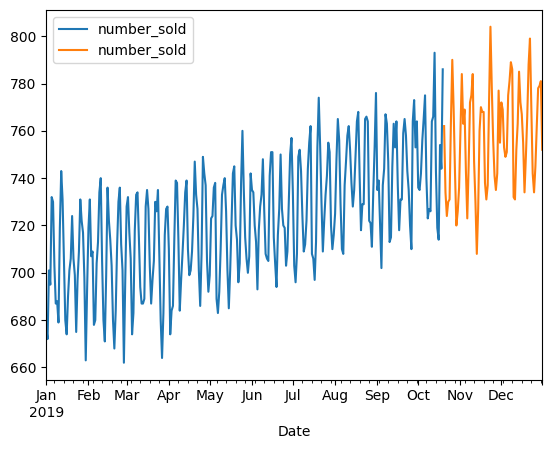

In [70]:
fig, ax= plt.subplots()
train.plot(ax = ax)
test.plot(ax = ax)

In [71]:
a.load_timeseries(pd.DataFrame(train))

In [72]:
a.build_model()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=2576.541, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=4675.260, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.34 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=2575.766, Time=0.31 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.31 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=2572.534, Time=0.58 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=2307.684, Time=0.63 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=2582.143, Time=0.20 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=2264.765, Time=0.27 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=2378.342, Time=0.55 sec
 ARIMA(5,0,2)(0,0,0)[0]             : AIC=inf, Time=0.59 sec
 ARIMA(4,0,3)(0,0,0)[0]             : AIC=inf, Time=1.04 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=2572.741, Time=0.86 s

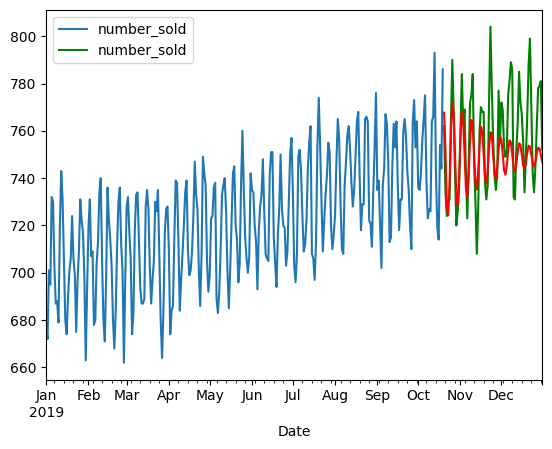

In [73]:
a.plot_test_forecast(test)